In [45]:
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy


In [46]:
! nvidia-smi 

zsh:1: command not found: nvidia-smi


In [47]:
class CNN(nn.Module):
    def __init__(self, 
                num_filters: int = 32, 
                hidden_dim: int = 128,
                kernel_size: int = 4,
                max_pool: int = 2,
                output_dim:int=10,
                width: int = 28,
                height: int = 28
                ):
        super().__init__()

        self.layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = kernel_size),
            nn.ReLU(),

            # Convolution 2
            nn.Conv2d(in_channels = num_filters, out_channels = num_filters, kernel_size = kernel_size),
            nn.ReLU(),

            # Max pooling
            nn.MaxPool2d(kernel_size=max_pool),

            # Dropoout 1
            nn.Dropout(p=0.25),

            # Flatten and fully connected (account for two convolutions and maxpooling in input dimension)
            nn.Flatten(),
            nn.Linear(in_features = (num_filters 
                                    * ((width - 2 * kernel_size + 2) // max_pool)
                                    * ((height - 2 * kernel_size + 2) // max_pool)), 
                      out_features = hidden_dim),
            nn.ReLU(),

            # Droput 2
            nn.Dropout(p=0.5),

            # Fully connected 2 
            nn.Linear(in_features = hidden_dim, out_features = output_dim)
        )
    def forward(self, x):
        x = self.layers(x)
        return x



In [48]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [49]:
def get_balanced_set(dataset, size):
    targets = np.array(dataset.targets)
    all_indices = np.arange(len(targets))

    samples_per_class = size//10

    indices = []

    for c in range(10):
        c_indices = all_indices[targets == c]

        indices.extend(np.random.choice(c_indices, size=samples_per_class, replace = False))
    
    return np.array(indices)


In [50]:
# All the indices of the trianing data
total_indices = np.arange(len(train_dataset))

# Initial Training Set: 20 random but balanced samples
train_indices = get_balanced_set(train_dataset, 20)

remaining_indices = np.setdiff1d(total_indices, train_indices)

# Get the 100 validation datapoints used to optimize the learning rate
validation_indices = np.random.choice(remaining_indices, size = 100, replace = False)

# Pool Set: Everything else
pool_indices = np.setdiff1d(remaining_indices, validation_indices)

# Initialise training dataset to the initial 20 datapoints
train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=64, shuffle=True)

pool_loader = DataLoader(Subset(train_dataset, pool_indices), batch_size=128, shuffle=False)

In [51]:
def train_model(model, train_indices, lr = 3e-4, weight_decay = 1e-6, n_epochs = 50):
    train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=128, shuffle=True)
    n_batches = len(train_loader)

    # Initialize model, optimizer and loss function 
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(n_epochs):

        pbar = tqdm.tqdm(enumerate(train_loader), total=n_batches, 
                               desc=f'Epoch {epoch + 1}/{n_epochs}')
        for batch_idx, (data, target) in pbar:
            optimizer.zero_grad()

            # Encode and decode data
            output = model(data)
            predicted = output.argmax(dim=1, keepdim = True)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix(loss = loss.item())
            #pbar.set_description(f'Epoch {epoch + 1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    return model


In [52]:
def test_model(model):
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    all_outputs = []

    correct = 0
    total = 0
    model.train()
    
    for batch_idx, (data, target) in (pbar:= tqdm.tqdm(enumerate(test_loader))):
        output = model(data)
        _, predicted = torch.max(output, dim=1)
        correct += (target == predicted).sum().item()
        all_outputs.append(output)

    accuracy = correct/len(all_outputs)
    return accuracy

In [53]:

lrs = [np.exp(-i) for i in np.linspace(1,5,5)]
lambdas = [np.exp(-i) for i in np.linspace(3,6,5)]


In [54]:
def validation(n_epochs=50):
    val_loader = DataLoader(Subset(train_dataset, validation_indices), batch_size = 100, shuffle = False)

    val_losses = []
    #lrs = [np.exp(-i) for i in np.linspace(1,5,10)]
    lambdas = [np.exp(-i) for i in np.linspace(3,6,10)]

    #hypers = list(itertools.product(lrs, lambdas))

    for wd in lambdas:
        model = CNN()
        model = train_model(model = model ,train_indices = train_indices, weight_decay = wd, n_epochs = n_epochs)
        model.train()

        for batch_idx, (data, target) in (pbar := tqdm.tqdm(enumerate(val_loader))):
            output = model(data)
            val_loss = nn.CrossEntropyLoss()(output, target)
            val_losses.append(val_loss.item())

    #opt_lr, opt_wd = hypers[np.argmin(val_losses)]#
    opt_wd = lambdas[np.argmin(val_losses)]
    return opt_wd #, opt_wd

#base_model = train_model(train_indices = train_indices, lr = opt_lr, weight_decay = opt_wd)

In [55]:
opt_wd = validation()
print(f"Opt wd: {opt_wd}")

Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 48.42it/s, loss=0.111]
1it [00:00, 56.47it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 53.69it/s, loss=0.0328]
1it [00:00, 52.74it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 60.87it/s, loss=0.0485]
1it [00:00, 50.43it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 43.74it/s, loss=0.0466]
1it [00:00, 47.29it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 61.08it/s, loss=0.0159]
1it [00:00, 46.67it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s, loss=0.0354]
1it [00:00, 47.63it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s, loss=0.0884]
1it [00:00, 48.19it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s, loss=0.0741]
1it [00:00, 45.65it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 54.94it/s, loss=0.0557]
1it [00:00, 39.99it/s]
Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s, loss=0.0358]
1it [00:00, 44.14it/s]


Opt wd: 0.004827949993831441


In [56]:
model = CNN()
base_model = train_model(model = model, train_indices = train_indices, lr = 1e-3, weight_decay = opt_wd, n_epochs = 50)
print(f"Base model test accuracy: {test_model(base_model)}")

Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s, loss=0.00603]
79it [00:01, 52.24it/s]


Base model test accuracy: 66.32911392405063


In [57]:
def calc_entropy(preds):
    # Input of shape T x N x dim_output

    # negative sum over C [(1/T sum over T p_c^t) * log(1/T sum over T p_c^t)]
    T,N,C = preds.shape

    mean_probs = torch.mean(preds, dim = 0) + 1e-10

    log_probs = torch.log(mean_probs)

    entropy = -torch.sum(mean_probs*log_probs, dim =1)

    return entropy

In [58]:
def calc_MI(preds):
    print(f"Calculating MI")
    entropy = calc_entropy(preds)

    T,N,C = preds.shape
    plogp = preds * torch.log(preds+1e-10)
    sum_T = torch.sum(plogp, dim  =0) #sum over T, leaving an N x C tensor
    sum_C = torch.sum(sum_T, dim = 1) #sum over C leaving a N dim tensor
    
    MI = entropy + 1/T*sum_C
    print(f"MI calc done")
    return MI


In [59]:
def calc_var_rat(preds):
    
    T,N,C = preds.shape

    max_indices = torch.argmax(preds, dim=2, keepdim = True)
    #print(f"max indices shape: {max_indices.shape}")

    one_hot = torch.zeros_like(preds, dtype = torch.float)
    #print(f"zeros: {one_hot.shape}")
    one_hot.scatter_(2, max_indices, 1.0)
    #print(f"one_hot scatter: {one_hot.shape}")

    sum_T = torch.sum(one_hot, dim=0)       # N x C 
    #print(f"sum over T: {sum_T.shape}")
    c_max = torch.argmax(sum_T, dim =1)         # Maximise over C
    #print(f"c_argmax: {c_max.shape}")
    f_x,_ = torch.max(sum_T, dim=1)         # N

    return 1-(f_x/T)


In [60]:
def calc_MSTD(preds):
    T,N,C = preds.shape

    mean_pred_squared = torch.mean(preds, dim=0)**2
    mean_squared_pred = torch.mean(preds**2, dim =0)

    sigmas = torch.sqrt((mean_squared_pred-mean_pred_squared))
    sigmas_c = torch.sum(sigmas, dim=1)

    return sigmas_c

In [61]:
def calc_uniform(preds):
    T,N,C = preds.shape
    uniform = torch.ones(N, dtype = torch.float)
    
    return uniform 

In [62]:
def get_TNC_preds(x, model, T):
    #print(f"getTNC:{x.shape}")
    N = x.shape[0]

    x_batch = x.repeat(T,1,1,1)

    #print(f"x_batch shape: {x_batch.shape}")

    #x_batch = x_tiled.reshape(T*N, -1)

    model.train()

    output = model(x_batch)
    output_TNC = output.reshape(T,N,-1)

    return output_TNC

In [63]:
def acquire_x(x, n, TNC_preds, acquisition_fn):
    acquisition_values = acquisition_fn(TNC_preds)

    _,acquired_indices = torch.topk(acquisition_values, k = n)

    acquired_x = x[acquired_indices]
    
    return acquired_x, acquired_indices

In [64]:
# Handling of data during training using each acquisition function 

import pickle 
#from google.colab import drive
#import os

global database
global filename

# 1. Mount your Google Drive (A window will pop up asking for authentication)
#drive.mount('/content/drive')

# 2. Define a path inside your Drive
#DRIVE_PATH = '/content/drive/MyDrive/UDL_Results/'

# Ensure the directory exists
#os.makedirs(DRIVE_PATH, exist_ok=True)

#filename = os.path.join(DRIVE_PATH, 'active_learning_results.png')                 
#filename = 'active_learning_results.png'

database = {}
filename = "acq_database"

acquisition_fns = {"MI":calc_MI}
#acquisition_fns = {"entropy":calc_entropy, "rvar_rat": calc_var_rat, "MI": calc_MI,"MSTD": calc_MSTD, "uniform": calc_uniform}

# Initiating an empy database which will store the accuracy after each acquisition step

for name in acquisition_fns:
    database[name] = []


def save_database(data, filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
    except Exception as e:
        print(f"Error saving database to {filename}: {e}")

def load_database(filename):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"No previous database found at {filename}. Starting fresh.")
        return {}
    except Exception as e:
        print(f"Error loading database from {filename}: {e}")
        return {}



In [67]:
def train_w_acquisition(T, base_model, train_dataset, train_indices, pool_indices, acq_fn_name, acq_fn, n_acq = 100, n_epochs=1, acq_batch_size = 64):
    global database
    global filename
    model = copy.deepcopy(base_model)               # Ensures base_model is not changed 
    train_indices_copy = train_indices.copy()
    pool_indices_copy = pool_indices.copy()
    #pool_indices_copy = pool_indices[0:1000]
    for i in range(n_acq):
        uncertainty_scores = []

        pool_data = DataLoader(Subset(train_dataset, pool_indices_copy), batch_size = acq_batch_size, shuffle = False)    # gets data from pool from which we will acquire new xs
        for batch_idx, (x_batch,_) in enumerate(pool_data):
            acq_values = acq_fn(get_TNC_preds(x_batch, model, T))

            # Helps with memory
            if isinstance(acq_values, torch.Tensor):
                scores = acq_values.detach().cpu().numpy()
            else:
                scores = acq_values
                
            uncertainty_scores.append(scores)
            
            # Delete unused values to help clear memory
            del x_batch, acq_values 
            torch.cuda.empty_cache() # Clear GPU cache if using CUDA

            print(f"Progress: {batch_idx/len(pool_data)}")
            
        uncertainty_scores = np.concatenate(uncertainty_scores)
        sorted_indices_in_scores = np.argsort(uncertainty_scores)[::-1]
        acquired_indices = sorted_indices_in_scores[:10]
        pool_indices_copy = np.setdiff1d(pool_indices_copy, acquired_indices)
        train_indices_copy = np.concatenate((train_indices_copy, acquired_indices))

        model = train_model(model = model, train_indices=train_indices_copy, lr = 1e-3, weight_decay = opt_wd, n_epochs = n_epochs)
        accuracy = test_model(model)
        database[acq_fn_name].append([(i+1)*10, accuracy])
        save_database(database, filename)
        

        print(f"Accuracy for acq_fn {acq_fn_name} at acq-step {(i+1)*10} is {accuracy}")

    
    return model


In [69]:
for key, value in acquisition_fns.items():
    model = train_w_acquisition(T=100, base_model=base_model, train_dataset = train_dataset, train_indices = train_indices, pool_indices=pool_indices, acq_fn_name = key, acq_fn = value, n_acq=100, n_epochs = 50)
    accuracy = test_model(model)

    print(f"Test accuracy for acquisition function: {key} = {accuracy}")

Calculating MI
MI calc done
Progress: 0.0
Calculating MI
MI calc done
Progress: 0.0010683760683760685
Calculating MI
MI calc done
Progress: 0.002136752136752137
Calculating MI
MI calc done
Progress: 0.003205128205128205
Calculating MI
MI calc done
Progress: 0.004273504273504274
Calculating MI
MI calc done
Progress: 0.005341880341880342
Calculating MI
MI calc done
Progress: 0.00641025641025641
Calculating MI
MI calc done
Progress: 0.007478632478632479
Calculating MI
MI calc done
Progress: 0.008547008547008548
Calculating MI
MI calc done
Progress: 0.009615384615384616
Calculating MI
MI calc done
Progress: 0.010683760683760684
Calculating MI
MI calc done
Progress: 0.011752136752136752
Calculating MI
MI calc done
Progress: 0.01282051282051282
Calculating MI
MI calc done
Progress: 0.013888888888888888
Calculating MI
MI calc done
Progress: 0.014957264957264958
Calculating MI
MI calc done
Progress: 0.016025641025641024
Calculating MI
MI calc done
Progress: 0.017094017094017096
Calculating MI


Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 41.82it/s, loss=0.003]
79it [00:01, 51.61it/s]


Accuracy for acq_fn MI at acq-step 10 is 72.77215189873418
Calculating MI
MI calc done
Progress: 0.0
Calculating MI
MI calc done
Progress: 0.0010683760683760685
Calculating MI
MI calc done
Progress: 0.002136752136752137
Calculating MI
MI calc done
Progress: 0.003205128205128205
Calculating MI
MI calc done
Progress: 0.004273504273504274
Calculating MI
MI calc done
Progress: 0.005341880341880342
Calculating MI
MI calc done
Progress: 0.00641025641025641
Calculating MI
MI calc done
Progress: 0.007478632478632479
Calculating MI
MI calc done
Progress: 0.008547008547008548
Calculating MI
MI calc done
Progress: 0.009615384615384616
Calculating MI
MI calc done
Progress: 0.010683760683760684
Calculating MI
MI calc done
Progress: 0.011752136752136752
Calculating MI
MI calc done
Progress: 0.01282051282051282
Calculating MI
MI calc done
Progress: 0.013888888888888888
Calculating MI
MI calc done
Progress: 0.014957264957264958
Calculating MI
MI calc done
Progress: 0.016025641025641024
Calculating MI


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_acquisition_curves(acq_names, database, file_name='acquisition_curves.png'):
    """
    Draws the acquisition step number vs. accuracy for specified acquisition functions 
    on a single graph using Matplotlib.

    Args:
        acq_names (list): List of acquisition function names (keys in the database).
        database (dict): Dictionary storing the results: 
                         database[name] = [[step_0, acc_0], [step_1, acc_1], ...]
        file_name (str): Name of the file to save the plot.
    """
    plt.figure(figsize=(10, 6))
    
    if not database:
        print("Error: The database is empty or None.")
        return

    all_data_found = False

    for name in acq_names:
        if name in database and database[name]:
            # Extract data for given acquisition function
            data_array = np.array(database[name])
            
            steps = data_array[:, 0]
            accuracies = data_array[:, 1]
            
            plt.plot(steps, accuracies, marker='o', linestyle='-', label=name)
            all_data_found = True
        else:
            print(f"Warning: Data not found for acquisition function '{name}'. Skipping.")

    if all_data_found:
        plt.title('Accuracy vs. Acquisition Step for Active Learning Strategies')
        plt.xlabel('Acquisition Step Number')
        plt.ylabel('Test Accuracy')
        plt.legend(title='Acquisition Function')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.plot()
        plt.savefig(file_name)
        plt.close()
        print(f"Plot saved successfully as {file_name}")
    else:
        print("Error: No valid data found for plotting.")

In [ ]:
print(database)

{'MI': [[10, 70.31645569620254], [20, 78.75949367088607], [30, 76.9493670886076], [40, 81.17721518987342], [50, 85.24050632911393], [60, 84.73417721518987], [70, 84.22784810126582], [80, 83.11392405063292], [90, 82.43037974683544], [100, 81.30379746835443], [110, 77.92405063291139], [120, 83.56962025316456], [130, 80.12658227848101], [140, 81.0379746835443], [150, 85.41772151898734], [160, 84.65822784810126], [170, 82.16455696202532], [180, 85.37974683544304], [190, 84.35443037974683], [200, 84.12658227848101]]}


Plot saved successfully as acquisition_curves.png


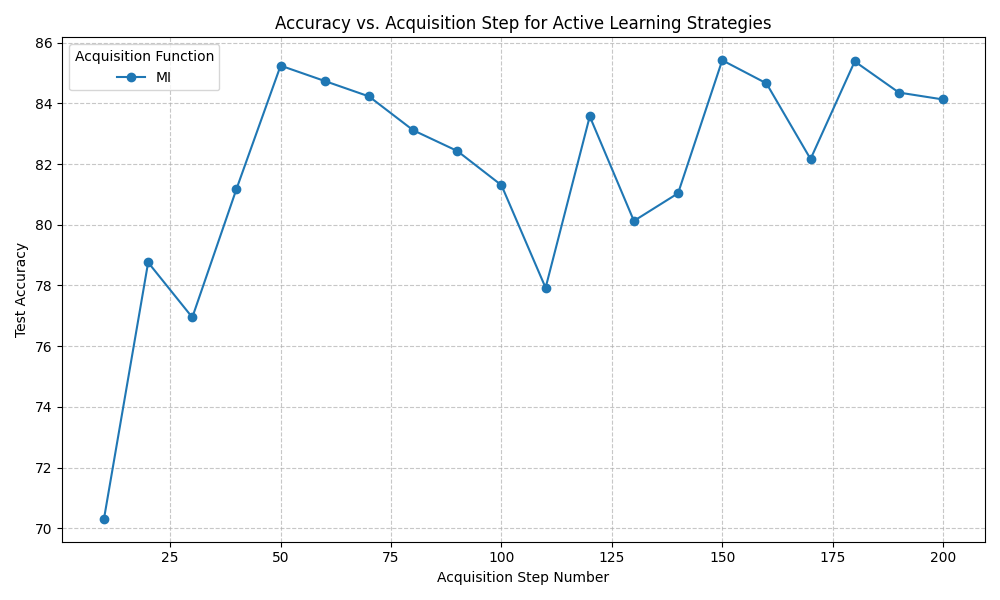

In [ ]:
from IPython.display import Image
acquisition_fns = {"entropy":calc_entropy, "MI": calc_MI}
plot_acquisition_curves(list(acquisition_fns.keys()), database = database)
Image(filename='acquisition_curves.png')

In [ ]:
def train_w_acquisition(T, model, train_dataset, train_indices, pool_indices, acquisition_fn, n_acq = 100, n_epochs=1, acq_batch_size = 128):
    train_indices_copy = train_indices.copy()
    pool_indices_copy = pool_indices.copy()

    for i in range(n_acq):
        considered_indices = pool_indices.copy()
        condition = False
        final = False
        while True: 
            pool_data = DataLoader(Subset(train_dataset, considered_indices.copy()), batch_size = acq_batch_size, shuffle = False)    # gets data from pool from which we will acquire new xs
            
            considered_indices = []

            for batch_idx, (x_batch,_) in enumerate(pool_data):
                acquired_x, acquired_indices = acquire_x(x_batch, 10, get_TNC_preds(x_batch, model ,T), acquisition_fn)
                print(f"Acquired indices: {acquired_indices}")

                considered_indices.append(acquired_indices)

            # Ensures we get final actual acquired indices when length of considered_indices is less than batch_size
            if (len(considered_indices)>128):
                condition = True
            if condition: 
                if final:
                    pool_indices_copy = np.setdiff1d(pool_indices_copy, considered_indices)
                    train_indices_copy = np.concatenate((train_indices_copy, considered_indices))
                    model = train_model(train_indices=train_indices_copy, lr = opt_lr, n_epochs = n_epochs)
                    break
                else:
                    final = True
    
    return model


In [ ]:
class analytic_inf_CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 4),
            nn.ReLU(),

            # Convolution 2
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 4),
            nn.ReLU(),

            # Max pooling
            nn.MaxPool2d(kernel_size=2),

            # Dropoout 1
            nn.Dropout(p=0.25),

            # Flatten and fully connected

            nn.Flatten(),
            nn.Linear(in_features = 32*11*11, out_features = hidden_dim),
            nn.ReLU(),

            # Droput 2
            nn.Dropout(p=0.5),
        )
        self.final_layer = nn.Linear(in_features = hidden_dim, out_features = output_dim)
    def forward(self, x):
        phi = self.layers(x)
        pred = self.final_layer(phi)
        return pred, phi

In [ ]:
def train_AI_model(model, train_indices, lr = 3e-4, weight_decay = 1e-6, n_epochs = 100, s = 1, sigma = 1):
    train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=64, shuffle=True)
    n_batches = len(train_loader)

    # Initialize model, optimizer and loss function 
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

    # Training loop
    for epoch in range(n_epochs):

        pbar = tqdm.tqdm(enumerate(train_loader), total=n_batches, 
                               desc=f'Epoch {epoch + 1}/{n_epochs}')
        for batch_idx, (data, target) in pbar:
            optimizer.zero_grad()

            # Change predictions to one-hot encodings
            target = F.one_hot(target, num_classes = 10)
            pred, phi = model(data)
            
            Sigma_dash = torch.linalg.inv((sigma**(-2)*phi@phi.T) + s**(-2))

            #mu_dash = sigma**(-2)*Sigma_dash@phi.T@target
    
            



            loss.backward()
            optimizer.step()
            
            pbar.set_postfix(loss = loss.item())
            #pbar.set_description(f'Epoch {epoch + 1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    return model


In [ ]:
N=1

for i in range(N):
    all_outputs = []
    for T in range(5):
        model = train_model(train_indices = train_indices, lr = opt_lr)
        output = test_model(model)
        all_outputs.append(output)
    all_outputs = torch.stack(all_outputs, dim =0)
    print(all_outputs.shape)

    acquired_indices = np.random.choice(pool_indices, size=10, replace= False)
    pool_indices = np.setdiff1d(pool_indices, acquired_indices)
    train_indices = np.concatenate((train_indices, acquired_indices))

    train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size = 64, shuffle = True)

    print(len(train_loader.dataset))



TypeError: train_model() missing 1 required positional argument: 'model'

In [ ]:

t1n1=[0.1,0.6,0.3]
t1n2=[0.0,0.8,0.2]
t1n3=[0.1,0.7,0.2]
t2n1=[0.1,0.2,0.7]
t2n2=[0.0,0.9,0.1]
t2n3=[0.8,0.1,0.1]


t1_predictions = torch.tensor([t1n1, t1n2, t1n3])

# T=2 Predictions: Shape (3, 3) -> N x C
t2_predictions = torch.tensor([t2n1, t2n2, t2n3])

# --- Step 2: Stack the T tensors along a new dimension (dim=0) ---
# Resulting shape: (T, N, C) -> (2, 3, 3)
tensor = torch.stack([t1_predictions, t2_predictions], dim=0)

print(tensor)

print(calc_var_rat(tensor))

# print(torch_tensor)
# print(torch_tensor.shape)
# print(calc_entropy(torch_tensor))

# print(f"Entropy shape: {calc_entropy(torch_tensor).shape}")

# print(calc_MI(torch_tensor))
# print(calc_MI(torch_tensor).shape)


tensor([[[0.1000, 0.6000, 0.3000],
         [0.0000, 0.8000, 0.2000],
         [0.1000, 0.7000, 0.2000]],

        [[0.1000, 0.2000, 0.7000],
         [0.0000, 0.9000, 0.1000],
         [0.8000, 0.1000, 0.1000]]])
max indices shape: torch.Size([2, 3, 1])
zeros: torch.Size([2, 3, 3])
one_hot scatter: torch.Size([2, 3, 3])
sum over T: torch.Size([3, 3])
c_argmax: torch.Size([3])
tensor([0.5000, 0.0000, 0.5000])


In [ ]:
def test_model(model):
    for batch_idx, (data,target) in (pbar:= tqdm.tqdm(enumerate(test_loader))):
        print()
        